The model that incorporated the auxiliary csv data seemed to cause the original CNN to perform worse, so I decided to bring back the original model. This is the final version of the 0.822 VGG19 model w/ Data Augmentation which will hopefully serve as a starting point for the implementation of future models. Everything should be run with GPU.

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import cv2
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
from keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split


print(tf.__version__)

2.2.0


Using TensorFlow backend.


In [2]:
training = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
print(training.head(10))

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   
5  ISIC_0074311  IP_2950485  female        40.0               lower extremity   
6  ISIC_0074542  IP_4698288    male        25.0               lower extremity   
7  ISIC_0075663  IP_6017204  female        35.0                         torso   
8  ISIC_0075914  IP_7622888    male        30.0                         torso   
9  ISIC_0076262  IP_5075533  female        50.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign  

In [3]:
print(training["target"].value_counts())

0    32542
1      584
Name: target, dtype: int64


In [4]:
print(training["anatom_site_general_challenge"].value_counts())

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64


We take a very small sample of the benign data to balance out the malignant data.

In [5]:
m = training[training["target"]==1]
b = training[training["target"]==0].sample(4000)
df = pd.concat([m,b])        
df.reset_index(inplace=True)
df.drop(labels=["index", "patient_id", "sex", "age_approx", "diagnosis", "benign_malignant"], axis=1, inplace=True)
df["image_name"] = "../input/images-siim-512x512/train/train_512x512/" + df["image_name"].astype(str) + ".jpg"
df.head()

,image_name,anatom_site_general_challenge,target
0,../input/images-siim-512x512/train/train_512x5...,upper extremity,1
1,../input/images-siim-512x512/train/train_512x5...,upper extremity,1
2,../input/images-siim-512x512/train/train_512x5...,torso,1
3,../input/images-siim-512x512/train/train_512x5...,torso,1
4,../input/images-siim-512x512/train/train_512x5...,lower extremity,1


In [6]:
df.shape

(4584, 3)

Load images and labels

In [7]:
imgs = []
labels = []
for index, row in tqdm(df.iterrows()):
    img = cv2.imread(str(row["image_name"]))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    labels.append(row["target"])
imgs = np.array(imgs)
labels = np.array(labels)
print(imgs.shape)
print(labels.shape)


4584it [00:39, 116.32it/s]


(4584, 224, 224, 3)
(4584,)


Add some augmentations

In [8]:
import random
def hairing(img):
        n_hairs = random.randint(0, 2)

        if not n_hairs:
            return img

        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir("../input/asdf1123/melanoma-hairs") if 'png' in im]

        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join("../input/asdf1123/melanoma-hairs", random.choice(hair_images)))
            b,g,r = cv2.split(hair)           # get b, g, r
            hair = cv2.merge([r,g,b]) # convert to rgb
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10,255,cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)
            
            
            
            dst = cv2.add(img_bg, hair_fg)
            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

        return img

In [9]:
df["image"] = None
for i in range (len(df["image"])):
    df["image"][i] = imgs[i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
del labels
gc.collect()

20

In [11]:
benign_train = df['target']==0
benign_train_df = df[benign_train]

benign_train_df_aug = benign_train_df.copy()
benign_train_df_aug_copy = pd.DataFrame(columns=["image_name", "anatom_site_general_challenge", "target", "image"])
for i in range (len(benign_train_df["image"])):
    if ((i % 4 == 1) & ((benign_train_df_aug["anatom_site_general_challenge"].iloc[i] == "torso") | (benign_train_df_aug["anatom_site_general_challenge"].iloc[i] == "palms/soles"))):
        benign_train_df_aug["image"].iloc[i] = hairing(benign_train_df_aug["image"].iloc[i])
        benign_train_df_aug_copy = benign_train_df_aug_copy.append(benign_train_df_aug.iloc[i], ignore_index = True)
benign_train_df_aug_copy['target'] = 0
df = pd.concat([df, benign_train_df_aug_copy], ignore_index=True, sort=False)

del benign_train_df_aug_copy
gc.collect()

notbenign_train = df['target']==1
notbenign_train_df = df[notbenign_train]

notbenign_train_df_aug = notbenign_train_df.copy()
notbenign_train_df_aug_copy = pd.DataFrame(columns=["image_name", "anatom_site_general_challenge", "target", "image"])
for i in range (len(notbenign_train_df["image"])):
    if (i % 3 == 1) & ((notbenign_train_df_aug["anatom_site_general_challenge"].iloc[i] == "torso") | (notbenign_train_df_aug["anatom_site_general_challenge"].iloc[i] == "palms/soles")):
        notbenign_train_df_aug["image"].iloc[i] = hairing(notbenign_train_df_aug["image"].iloc[i])
        notbenign_train_df_aug_copy = notbenign_train_df_aug_copy.append(notbenign_train_df_aug.iloc[i], ignore_index=True)
notbenign_train_df_aug_copy['target'] = 1
df = pd.concat([df, notbenign_train_df_aug_copy], ignore_index=True, sort=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
df.shape

(5210, 4)

In [13]:
df.tail(5)

,image_name,anatom_site_general_challenge,target,image
5205,../input/images-siim-512x512/train/train_512x5...,torso,1,"[[[60, 46, 35], [66, 52, 41], [61, 44, 34], [6..."
5206,../input/images-siim-512x512/train/train_512x5...,torso,1,"[[[142, 95, 53], [145, 96, 55], [148, 98, 57],..."
5207,../input/images-siim-512x512/train/train_512x5...,torso,1,"[[[151, 131, 130], [159, 139, 140], [158, 140,..."
5208,../input/images-siim-512x512/train/train_512x5...,torso,1,"[[[15, 14, 13], [20, 16, 13], [20, 15, 11], [1..."
5209,../input/images-siim-512x512/train/train_512x5...,torso,1,"[[[199, 127, 145], [200, 129, 147], [200, 132,..."


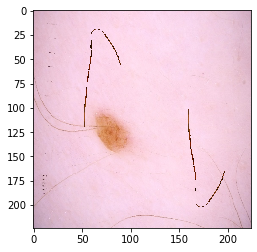

In [14]:
from matplotlib import pyplot as plt
plt.imshow(df["image"].iloc[5000], interpolation='nearest')
plt.show()

In [15]:
print(df["anatom_site_general_challenge"].value_counts())

torso              2913
lower extremity    1135
upper extremity     735
head/neck           293
palms/soles          51
oral/genital         19
Name: anatom_site_general_challenge, dtype: int64


In [16]:
print(df["target"].value_counts())

0    4536
1     674
Name: target, dtype: int64


In [17]:
len(df["image"])

5210

In [18]:
imgs = []
labels = []
for i in range(len(df["image"])):
    img = df["image"].iloc[i]
    imgs.append(img)
    labels.append(df["target"].iloc[i])
imgs = np.array(imgs)
labels = np.array(labels)

In [19]:
with open("res_imgs4k.npz", "wb") as file:
    np.savez_compressed(file, images=imgs)

In [20]:
with open("./res_imgs4k.npz", "rb") as file:
    imgs = np.load(file)["images"]

Note that we set the random_state in the train-test split as 420. This means the model will be very lucky.

In [21]:
#labels = np.concatenate([np.full(584,1),np.full(4000,0)])
#print(imgs.shape)
#print(labels.shape)

2645

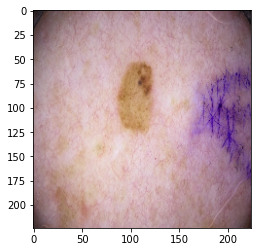

In [22]:
trainX, valX, trainY, valY = train_test_split(imgs, labels, test_size=0.2, random_state=420)
plt.imshow(trainX[0])
del imgs, labels
gc.collect()

In [23]:
# trainX, valX, trainY, valY = train_test_split(
#     df["image_name"], 
#     df["target"],
#     test_size = 0.2, 
#     random_state = 888
# )
# train = list(zip(trainX, trainY))
# train = pd.DataFrame(train, columns = ["images", "target"])
# val = list(zip(valX, valY))
# val = pd.DataFrame(val, columns = ["images", "target"])

# train.head()

In [24]:
train_aug = ImageDataGenerator(rescale=1./255,
                     rotation_range=60,
                     width_shift_range=0.2, 
                     height_shift_range=0.2,
                     shear_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True)

val_aug = ImageDataGenerator(rescale=1./255)

In [25]:
train_gen = train_aug.flow(trainX, trainY, batch_size = 12, shuffle = True)
val_gen = val_aug.flow(valX, valY, batch_size = 12, shuffle = False)

Flow from dataframe reads in images from disk given the filepaths (stored under column "images").

In [26]:
# train_gen = train_aug.flow_from_dataframe(train, x_col="images", y_col="target", batch_size = 8, target_size=(224,224),shuffle = True, class_mode="raw")
# val_gen = val_aug.flow_from_dataframe(val, x_col="images", y_col="target", batch_size = 8, target_size=(224,224),shuffle = False, class_mode="raw")

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=2)
checkpoint = ModelCheckpoint("{val_loss:.2f}-{epoch:02d}.hdf5",monitor = 'val_loss',verbose = 1,save_best_only = True,mode = 'min')

callbacks = [early_stop, checkpoint]

In [28]:
from tensorflow.python.keras import backend as K
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [29]:
optimizer = keras.optimizers.Adam(lr=1e-5)
auc = keras.metrics.AUC()

ResNet with our own top layer. ResNet is frozen.

In [30]:
resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape = (224,224,3))
resnet.trainable=False
flat = Flatten()(resnet.output)
# gap = GlobalAveragePooling2D()(resnet.output)
final = Dropout(0.5)(flat)
final = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(final)
final = Dropout(0.4)(final)
final = Dense(1, activation="sigmoid")(final)
model = Model(resnet.input,final)
model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____________________________

In [31]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

history = model.fit_generator(
    train_gen,
    steps_per_epoch = trainX.shape[0] // 12,
    epochs = 3, 
    validation_data = val_gen,
    validation_steps = valX.shape[0] // 12
)

#model.save('resnet2.h5')

Epoch 1/3
347/347 [==============================] - 54s 156ms/step - loss: 0.7128 - accuracy: 0.8556 - val_loss: 0.4562 - val_accuracy: 0.8682
Epoch 2/3
347/347 [==============================] - 53s 152ms/step - loss: 0.4916 - accuracy: 0.8691 - val_loss: 0.4256 - val_accuracy: 0.8682
Epoch 3/3
347/347 [==============================] - 51s 148ms/step - loss: 0.4965 - accuracy: 0.8713 - val_loss: 0.4319 - val_accuracy: 0.8682


In [32]:
for layer in resnet.layers[154:]:
   layer.trainable = True
for i, layer in enumerate(resnet.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [33]:
opt = keras.optimizers.Adamax(learning_rate=1e-5)

In [34]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)

history = model.fit_generator(
    train_gen,
    steps_per_epoch = trainX.shape[0] // 12,
    epochs = 10, 
    validation_data = val_gen,
    validation_steps = valX.shape[0] // 12,
    callbacks = callbacks
)

Epoch 1/10
347/347 [==============================] - ETA: 0s - loss: 0.5397 - accuracy: 0.8703
Epoch 00001: val_loss improved from inf to 0.44011, saving model to 0.44-01.hdf5
347/347 [==============================] - 56s 163ms/step - loss: 0.5397 - accuracy: 0.8703 - val_loss: 0.4401 - val_accuracy: 0.8663
Epoch 2/10
347/347 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.8701
Epoch 00002: val_loss improved from 0.44011 to 0.41298, saving model to 0.41-02.hdf5
347/347 [==============================] - 55s 157ms/step - loss: 0.4758 - accuracy: 0.8701 - val_loss: 0.4130 - val_accuracy: 0.8663
Epoch 3/10
347/347 [==============================] - ETA: 0s - loss: 0.4392 - accuracy: 0.8720
Epoch 00003: val_loss improved from 0.41298 to 0.39821, saving model to 0.40-03.hdf5
347/347 [==============================] - 54s 156ms/step - loss: 0.4392 - accuracy: 0.8720 - val_loss: 0.3982 - val_accuracy: 0.8663
Epoch 4/10
347/347 [==============================] - ETA: 

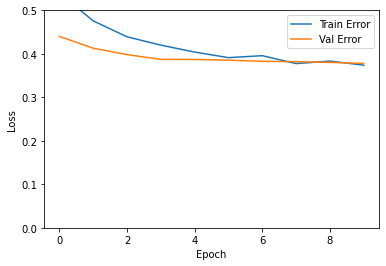

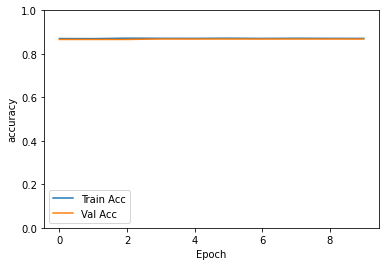

In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist['epoch'], hist['loss'], label='Train Error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
plt.ylim([0, 0.5])
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(hist['epoch'], hist['accuracy'], label='Train Acc')
plt.plot(hist['epoch'], hist['val_accuracy'], label='Val Acc')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [36]:
del trainX, trainY, valX, valY
gc.collect()

5175

In [37]:
testing = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
testing.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [38]:
test_images = np.load("../input/siimisic-melanoma-resized-images/x_test_224.npy")
predictions = []
i=0
for img in tqdm(test_images):       
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,224,224,3))       
    pred=model.predict(img)
    predictions.append(pred[0][0])
    i+=1
    if (i==51):
        print(predictions[:50])
    del img
    gc.collect()


  0%|          | 51/10982 [00:12<44:48,  4.07it/s]

[0.0072392104, 0.11705914, 0.00928761, 4.2822703e-06, 0.22353089, 0.09864742, 0.021710498, 0.19223666, 0.1902167, 0.025308546, 0.058458306, 0.00022306941, 0.16587508, 0.0017921594, 0.26862782, 0.0049313284, 0.016396703, 0.0012967463, 0.10782742, 0.25972506, 0.09804438, 0.03524015, 0.18734965, 0.05939615, 0.3572964, 0.012294999, 0.00035688948, 0.00026781327, 0.0038341954, 0.0011909929, 0.019555388, 0.0028290555, 0.138351, 0.26887947, 0.2703944, 0.03226124, 0.06659514, 0.30545008, 0.0058811354, 0.032933667, 0.0013514546, 0.27071673, 0.32008463, 0.0047839684, 0.0012628362, 0.30173635, 0.2719577, 0.0076025627, 0.0003212019, 0.21560523]


100%|██████████| 10982/10982 [42:02<00:00,  4.35it/s]


In [39]:
len(predictions)

10982

In [40]:
results = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
results['target'] = predictions
results.to_csv('resnet2.csv', header=True, index=False)

In [41]:
results.head()

,image_name,target
0,ISIC_0052060,0.007239
1,ISIC_0052349,0.117059
2,ISIC_0058510,0.009288
3,ISIC_0073313,0.000004
4,ISIC_0073502,0.223531
